In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import umap
from sklearn.preprocessing import MinMaxScaler 

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'2.2.0'

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [45]:
from ood_detection_helper import *

## Resuming from ckpt 9

In [8]:
model = load_model(inlier_name="cifar10", checkpoint=9)

Parameters: 

experiment: train
dataset: cifar10
model: refinenet
filters: 128
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 1000
samples_dir: ./samples/
checkpoint_dir: saved_models/
checkpoint_freq: 5000
resume: True
resume_from: 9
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2

(1, 32, 32, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        images[0][0]                     
________________________________________________________________________________________

## Loading OOD datasets

In [39]:
x = tf.random.normal(shape=(TEST_BATCH*10, 32,32,3) , mean=0.5, stddev=1.0)
x = tf.clip_by_value(x, 0.0, 1.0)
gaussian_test_batches = tf.split(x, 10)

In [40]:
x = tf.random.uniform(shape=(TEST_BATCH*10, 32,32,3), minval=0.0, maxval=1.0)
uniform_test_batches = tf.split(x, 10)

In [13]:
svhn_test_batches = []

with tf.device('CPU'):
    data_generators = tfds.load(name="svhn_cropped", batch_size=-1, data_dir="data", shuffle_files=True)
    svhn_test = tf.data.Dataset.from_tensor_slices(data_generators['test']).take(10000)
    svhn_test = svhn_test.batch(TEST_BATCH)
    
    for x in svhn_test:
        svhn_test_batches.append(x["image"] / 255)

In [14]:
cifar_test_batches = []

with tf.device('CPU'):
    data_generators = tfds.load(name="cifar10", batch_size=-1, data_dir="data", shuffle_files=True)
    cifar_test_ = tf.data.Dataset.from_tensor_slices(data_generators['test']).batch(TEST_BATCH)
    for x in cifar_test_:
        cifar_test_batches.append(x["image"] / 255)

In [41]:
outlier_datasets = (svhn_test_batches, gaussian_test_batches, uniform_test_batches)

## Calculating Scores

In [67]:
LABELS = np.array(["Train", "CIFAR", "SVHN", "Gaussian", "Uniform"])
colors = ["red", "blue", "green", "orange"]
COLORS = sns.color_palette("bright")

In [20]:
%%time
inlier_dist = compute_scores(model, cifar_test_batches)

Sigma: 0.0100: 100%|██████████| 10/10 [03:06<00:00, 18.70s/it]

CPU times: user 58.8 s, sys: 58.1 s, total: 1min 56s
Wall time: 3min 6s


In [42]:
%%time
outlier_dists = []
progress_bar = tqdm(zip(LABELS[2:], outlier_datasets))

for name, outlier in progress_bar:
    progress_bar.set_description(name)
    outlier_dists.append(compute_scores(model, outlier))

SVHN: : 0it [00:00, ?it/s]
Sigma: 0.0100: 100%|██████████| 10/10 [03:03<00:00, 18.35s/it]
Gaussian: : 1it [03:03, 183.50s/it]
Sigma: 0.0100: 100%|██████████| 10/10 [03:04<00:00, 18.43s/it]
Uniform: : 2it [06:08, 184.02s/it] 
Sigma: 0.0100: 100%|██████████| 10/10 [03:04<00:00, 18.44s/it]
Uniform: : 3it [09:14, 184.68s/it]

CPU times: user 2min 52s, sys: 2min 28s, total: 5min 20s
Wall time: 9min 14s


In [53]:
SIGMAS = utils.get_sigma_levels().numpy()

In [47]:
SIGMAS 

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)>

In [80]:
@tf.function(experimental_compile=True)
def weighted_sum(x):
    x = tf.add_n([x[i] * s for i, s in enumerate(SIGMAS)])
    return reduce_norm(x)

In [82]:
%%time

inlier_score = weighted_sum(inlier_dist).numpy()
outlier_scores = []
for _dists in outlier_dists:
    outlier_scores.append(weighted_sum(_dists).numpy())

CPU times: user 8.58 ms, sys: 6.42 ms, total: 15 ms
Wall time: 11.8 ms


In [83]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18

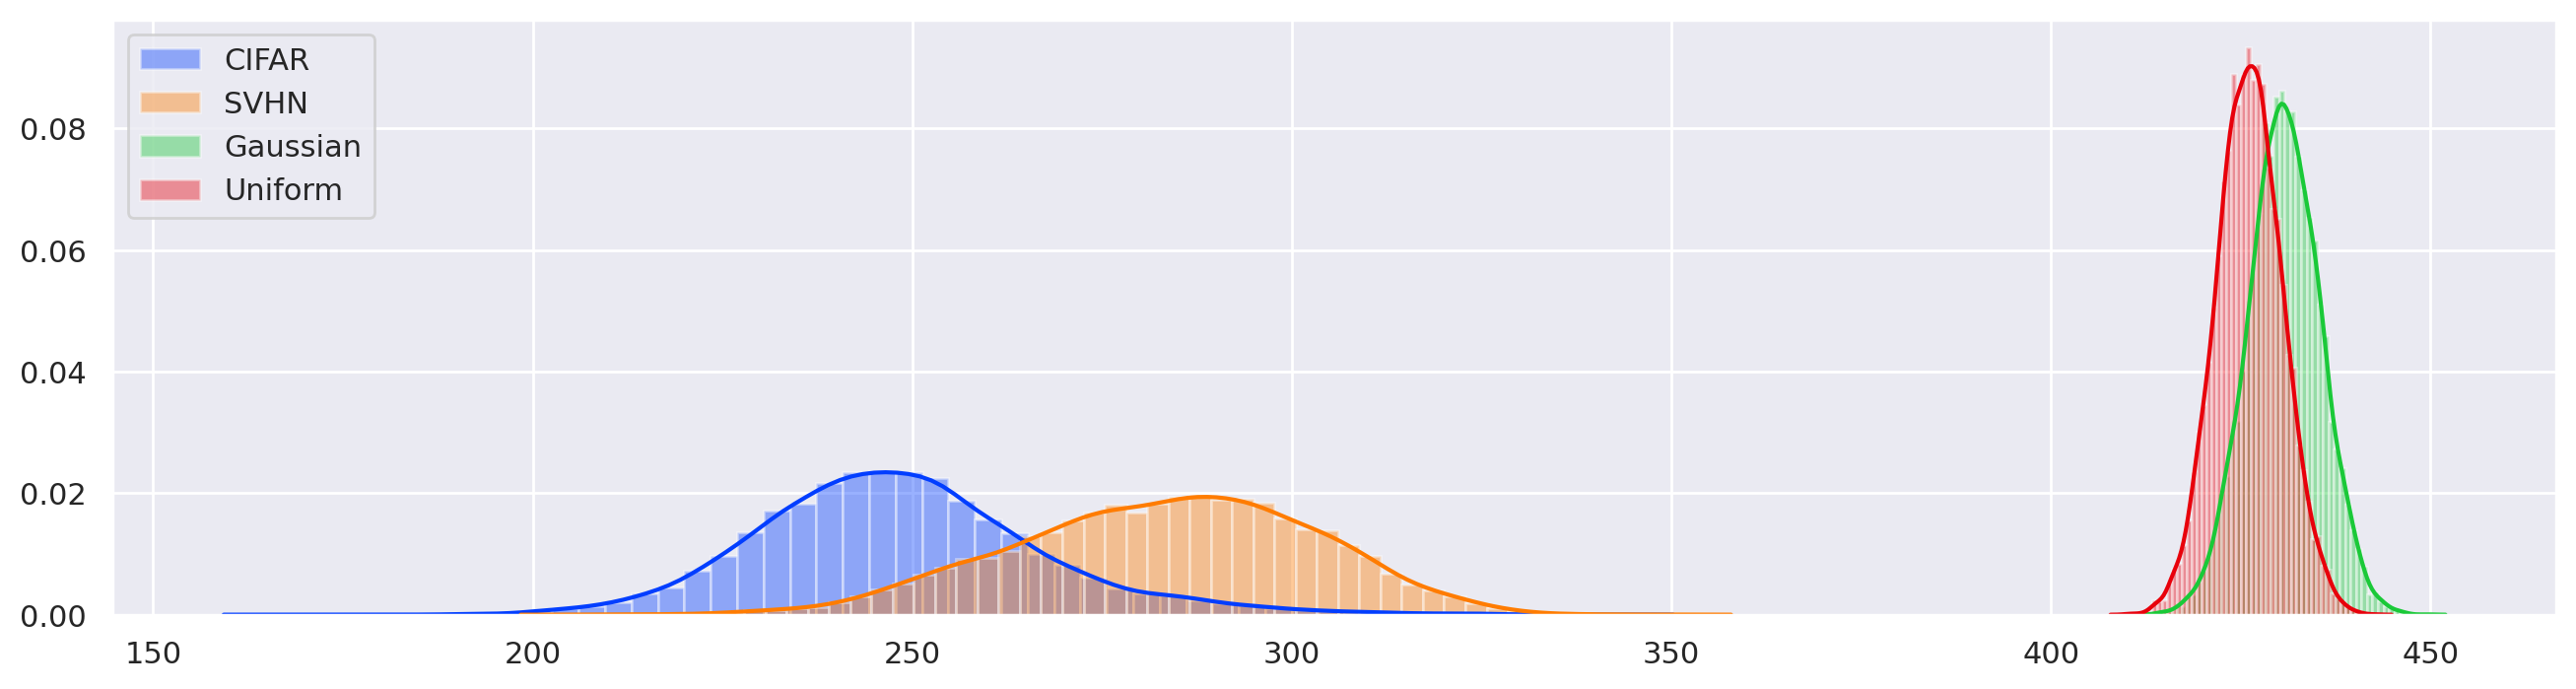

In [84]:
fig, ax = plt.subplots(1,1, figsize=(16,4))

for idx, sc in enumerate((inlier_score, *outlier_scores)):
    sns.distplot(sc, label=LABELS[idx+1], color=COLORS[idx], ax=ax)
plt.legend()
plt.show()

**CIFAR vs SVHN**

In [76]:
outlier_scores[0]

array([[159.2068 , 167.24196, 167.15596],
       [178.63817, 194.00931, 172.73215],
       [157.36397, 175.27829, 173.02888],
       ...,
       [154.87215, 166.62059, 143.67155],
       [156.39745, 172.10129, 160.06374],
       [149.57643, 169.45753, 154.00914]], dtype=float32)

In [85]:
metrics(inlier_score, outlier_scores[0], plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9000
PR-AUC: 0.8877
Avg Prec: 0.8877


## Train Data = L2-norm(Pixel Scores)

In [92]:
@tf.function(experimental_compile=True)
def weighted_norm(x):
    x = tf.concat([reduce_norm(x[i] * s) for i, s in enumerate(SIGMAS)], axis=1)
    return x

In [96]:
%%time
inlier_scores = weighted_norm(inlier_dist).numpy()
outlier_scores = []
for _dists in outlier_dists:
    outlier_scores.append(weighted_norm(_dists).numpy())

CPU times: user 3.38 ms, sys: 13.7 ms, total: 17.1 ms
Wall time: 13.9 ms


In [97]:
X_train, X_test =  inlier_scores[:9000], inlier_scores[9000:]

In [82]:
samples = np.concatenate((test_data, outlier_data_1, outlier_data_2))

labels = np.concatenate((np.zeros(test_data.shape[0]),
                         np.ones(outlier_data_1.shape[0]),
                         2*np.ones(outlier_data_2.shape[0])))
captions = np.concatenate([[LABELS[idx]]*shapes[idx-1][0] for idx in range(1,4)])

## GMM

In [74]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(2,30,2),
                  GMM__covariance_type = ['full']) # Full always performs best 

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done 140 out of 140 | elapsed:   48.7s finished


CPU times: user 1min 42s, sys: 1min 31s, total: 3min 14s
Wall time: 53.2 s


Best: 2.359903 using {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
---------------------------------------------------------------------------
2.041079 (0.106348) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.250401 (0.093054) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.314128 (0.107954) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.343701 (0.084953) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.352568 (0.091028) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.359903 (0.096867) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.358067 (0.095448) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.343326 (0.090795) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.328146 (0.103001) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.311616 (0.104930) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
2.308665 

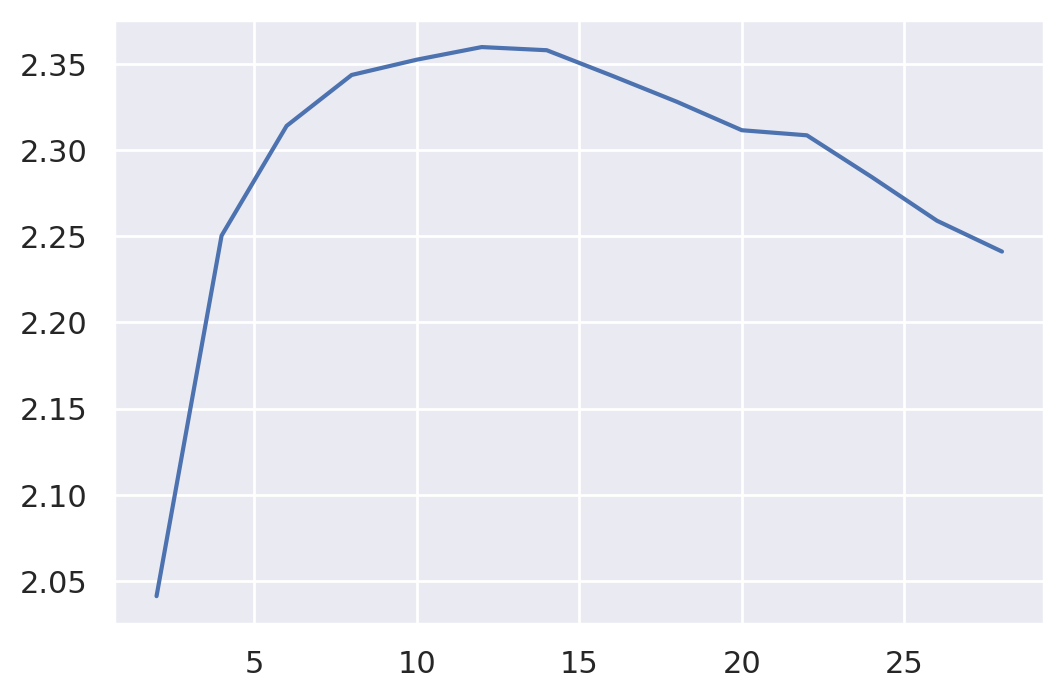

In [75]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
plt.plot([p["GMM__n_components"] for p in params], means)

In [76]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
#     ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)

best_gmm_clf.fit(X_train)

Pipeline(steps=[('GMM', GaussianMixture(n_components=12))])

In [77]:
print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_data_2)))

Training Likelihood: -6.243
CIFAR Likelihood: -6.242
CelebA Likelihood: -7.961
SVHN Likelihood: -14.155


In [78]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

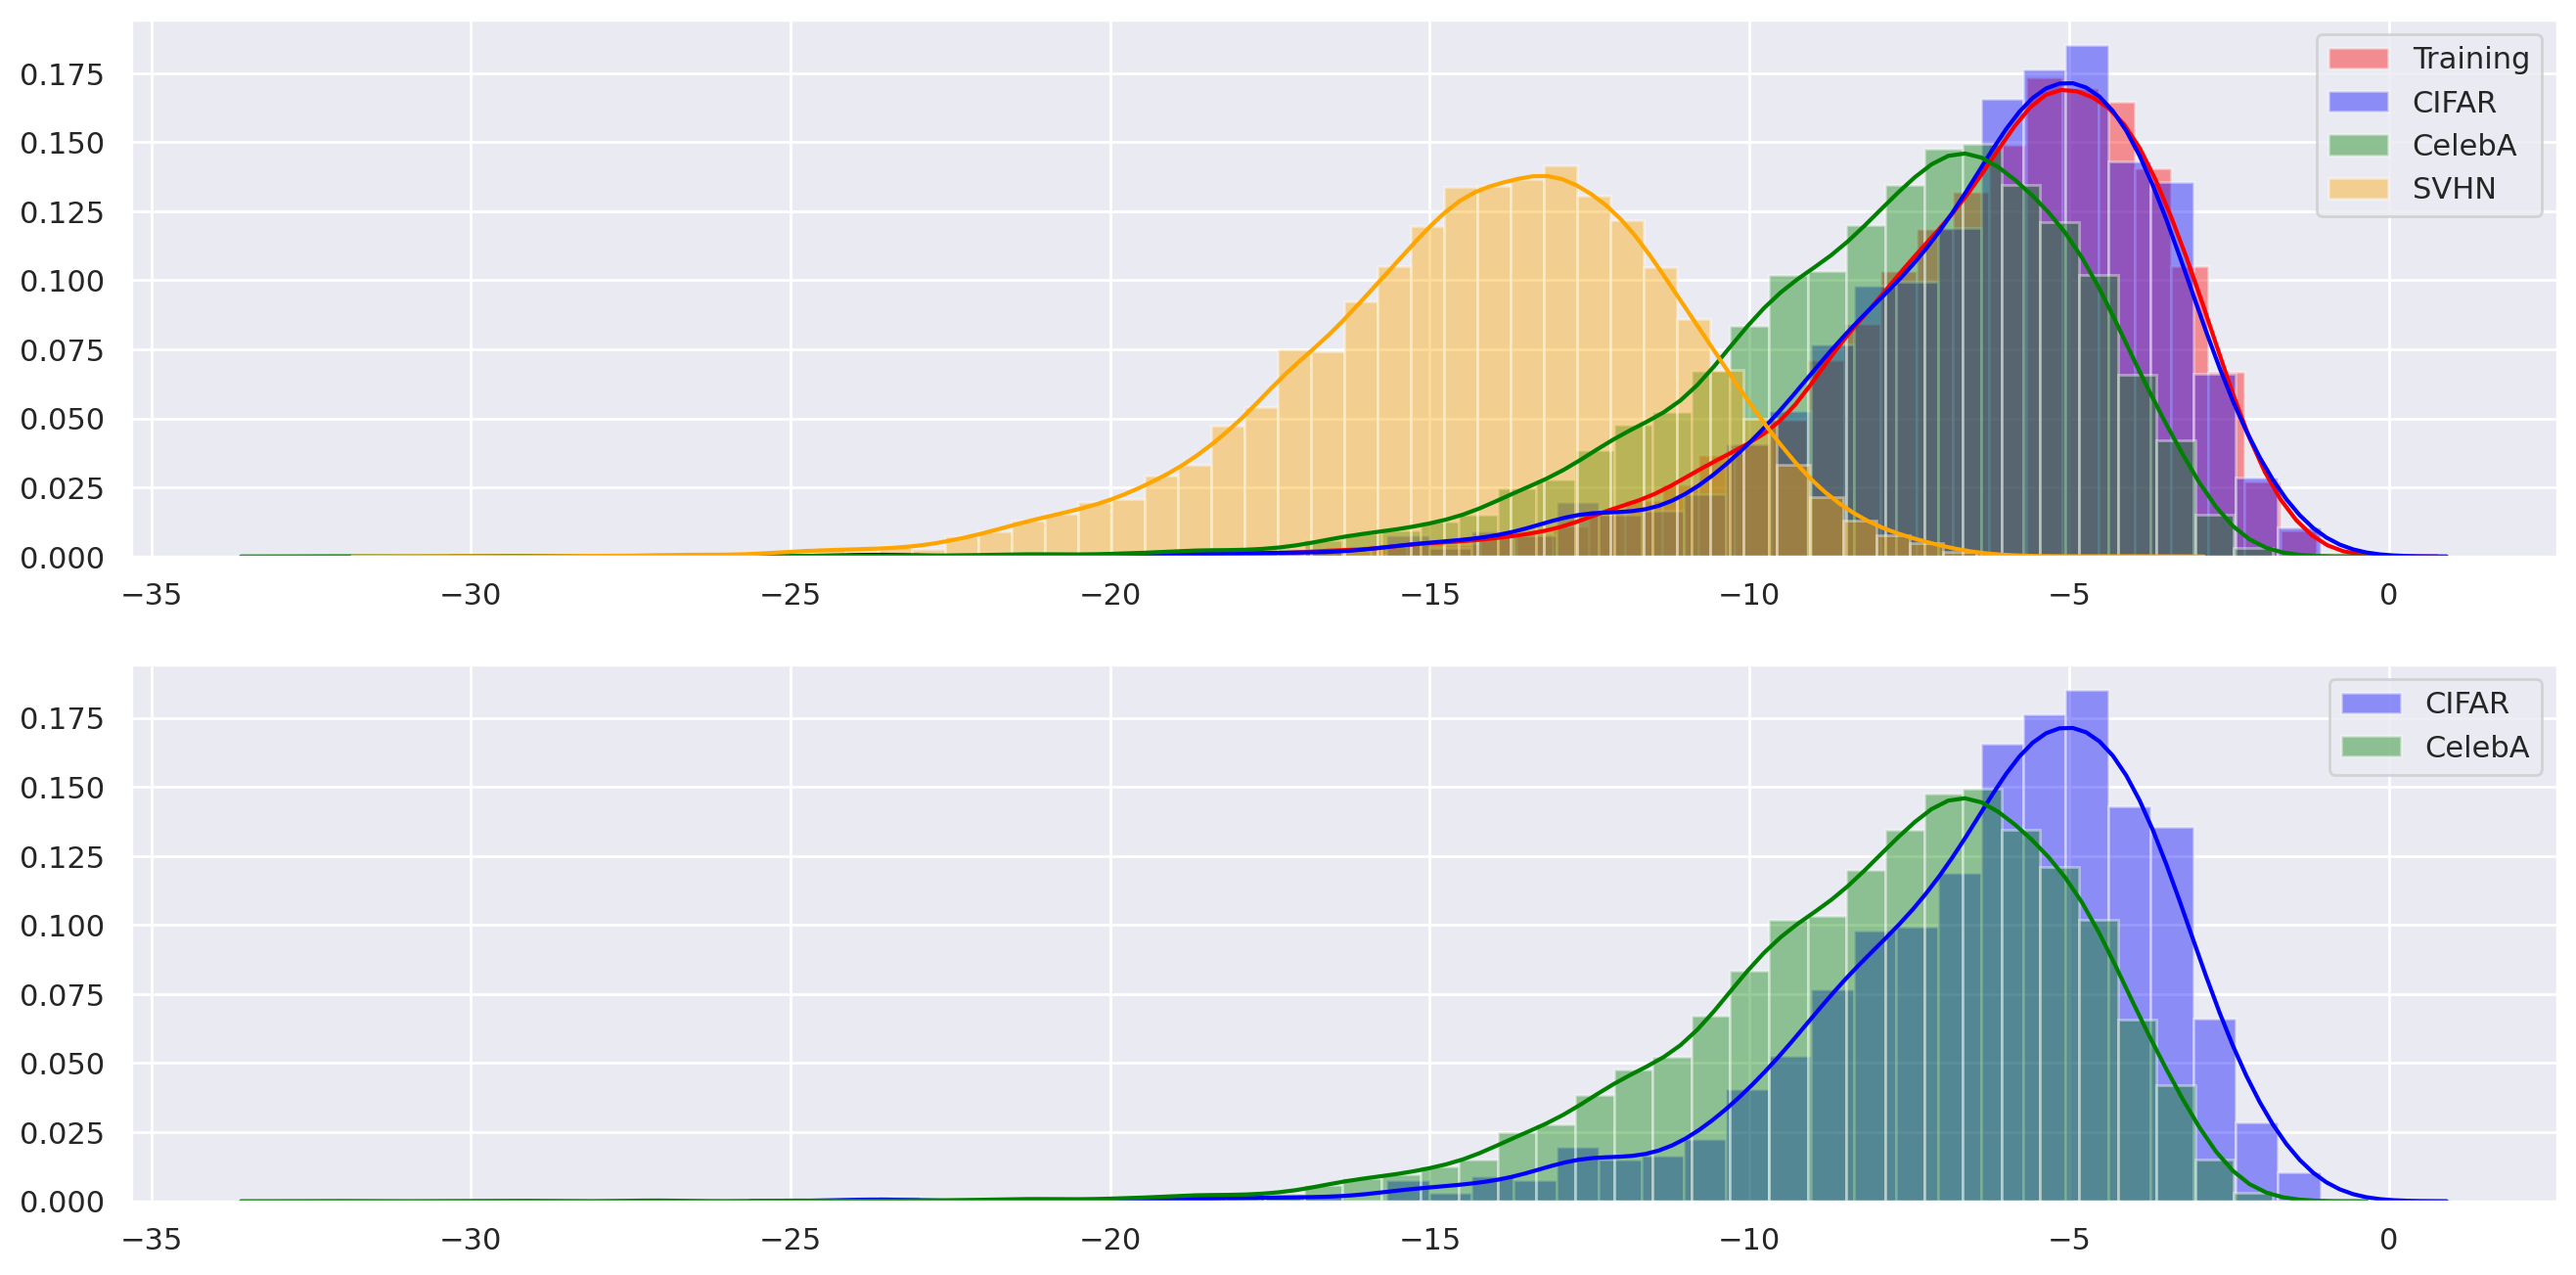

In [79]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

**CIFAR vs CelebA**

In [80]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.6756
PR-AUC: 0.9471
Avg Prec: 0.9472


**CIFAR vs SVHN**

In [81]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9706
PR-AUC: 0.9955
Avg Prec: 0.9955


### Flow Models

In [67]:
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [68]:
X_train.shape

(9000, 10)

In [78]:
# Density estimation with MADE.
n = X_train.shape[0]
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[512, 512], activation="elu")

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[10])

# Construct and fit model.
x_ = tfkl.Input(shape=(10,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob)

batch_size = 128
epochs = 500
history = model.fit(
    x=X_train,
    y=np.zeros((n, 0), dtype=np.float32),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=n//batch_size,  # Usually `n // batch_size`.
    shuffle=True,
    verbose=True)

Epoch 1/500
70/70 [==============================] - 0s 3ms/step - loss: 595.5113
Epoch 2/500
70/70 [==============================] - 0s 3ms/step - loss: 456.9963
Epoch 3/500
70/70 [==============================] - 0s 3ms/step - loss: 395.8909
Epoch 4/500
70/70 [==============================] - 0s 3ms/step - loss: 350.1944
Epoch 5/500
70/70 [==============================] - 0s 3ms/step - loss: 312.3556
Epoch 6/500
70/70 [==============================] - 0s 3ms/step - loss: 282.7817
Epoch 7/500
70/70 [==============================] - 0s 3ms/step - loss: 255.0613
Epoch 8/500
70/70 [==============================] - 0s 3ms/step - loss: 232.3367
Epoch 9/500
70/70 [==============================] - 0s 3ms/step - loss: 213.4885
Epoch 10/500
70/70 [==============================] - 0s 2ms/step - loss: 195.8918
Epoch 11/500
70/70 [==============================] - 0s 2ms/step - loss: 179.8792
Epoch 12/500
70/70 [==============================] - 0s 2ms/step - loss: 167.6611
Epoch 13/500


Epoch 199/500
70/70 [==============================] - 0s 2ms/step - loss: 10.0903
Epoch 200/500
70/70 [==============================] - 0s 2ms/step - loss: 9.9440
Epoch 201/500
70/70 [==============================] - 0s 2ms/step - loss: 9.9763
Epoch 202/500
70/70 [==============================] - 0s 2ms/step - loss: 9.9189
Epoch 203/500
70/70 [==============================] - 0s 2ms/step - loss: 9.8165
Epoch 204/500
70/70 [==============================] - 0s 2ms/step - loss: 12.4519
Epoch 205/500
70/70 [==============================] - 0s 3ms/step - loss: 10.7042
Epoch 206/500
70/70 [==============================] - 0s 2ms/step - loss: 11.1730
Epoch 207/500
70/70 [==============================] - 0s 2ms/step - loss: 10.9835
Epoch 208/500
70/70 [==============================] - 0s 2ms/step - loss: 9.8315
Epoch 209/500
70/70 [==============================] - 0s 2ms/step - loss: 12.3872
Epoch 210/500
70/70 [==============================] - 0s 2ms/step - loss: 16.0003
Epoch 211

70/70 [==============================] - 0s 3ms/step - loss: 8.9210
Epoch 398/500
70/70 [==============================] - 0s 3ms/step - loss: 9.1400
Epoch 399/500
70/70 [==============================] - 0s 4ms/step - loss: 8.8122
Epoch 400/500
70/70 [==============================] - 0s 3ms/step - loss: 8.8768
Epoch 401/500
70/70 [==============================] - 0s 3ms/step - loss: 8.7858
Epoch 402/500
70/70 [==============================] - 0s 3ms/step - loss: 9.5148
Epoch 403/500
70/70 [==============================] - 0s 3ms/step - loss: 8.6765
Epoch 404/500
70/70 [==============================] - 0s 3ms/step - loss: 9.1242
Epoch 405/500
70/70 [==============================] - 0s 3ms/step - loss: 9.3093
Epoch 406/500
70/70 [==============================] - 0s 4ms/step - loss: 8.6174
Epoch 407/500
70/70 [==============================] - 0s 3ms/step - loss: 8.6455
Epoch 408/500
70/70 [==============================] - 0s 4ms/step - loss: 8.6164
Epoch 409/500
70/70 [=========

70/70 [==============================] - 0s 2ms/step - loss: 7.8035
Epoch 498/500
70/70 [==============================] - 0s 3ms/step - loss: 7.7817
Epoch 499/500
70/70 [==============================] - 0s 2ms/step - loss: 7.9669
Epoch 500/500
70/70 [==============================] - 0s 2ms/step - loss: 7.8081


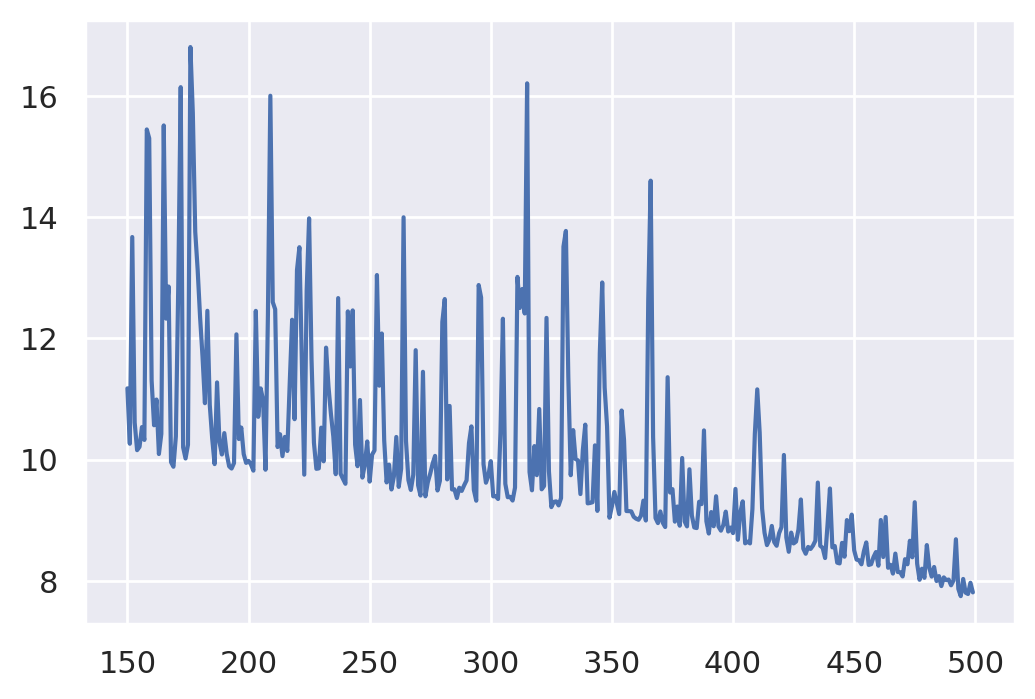

In [82]:
start_idx=150
plt.plot(range(start_idx, epochs), history.history["loss"][start_idx:])
# plt.yscale("log")

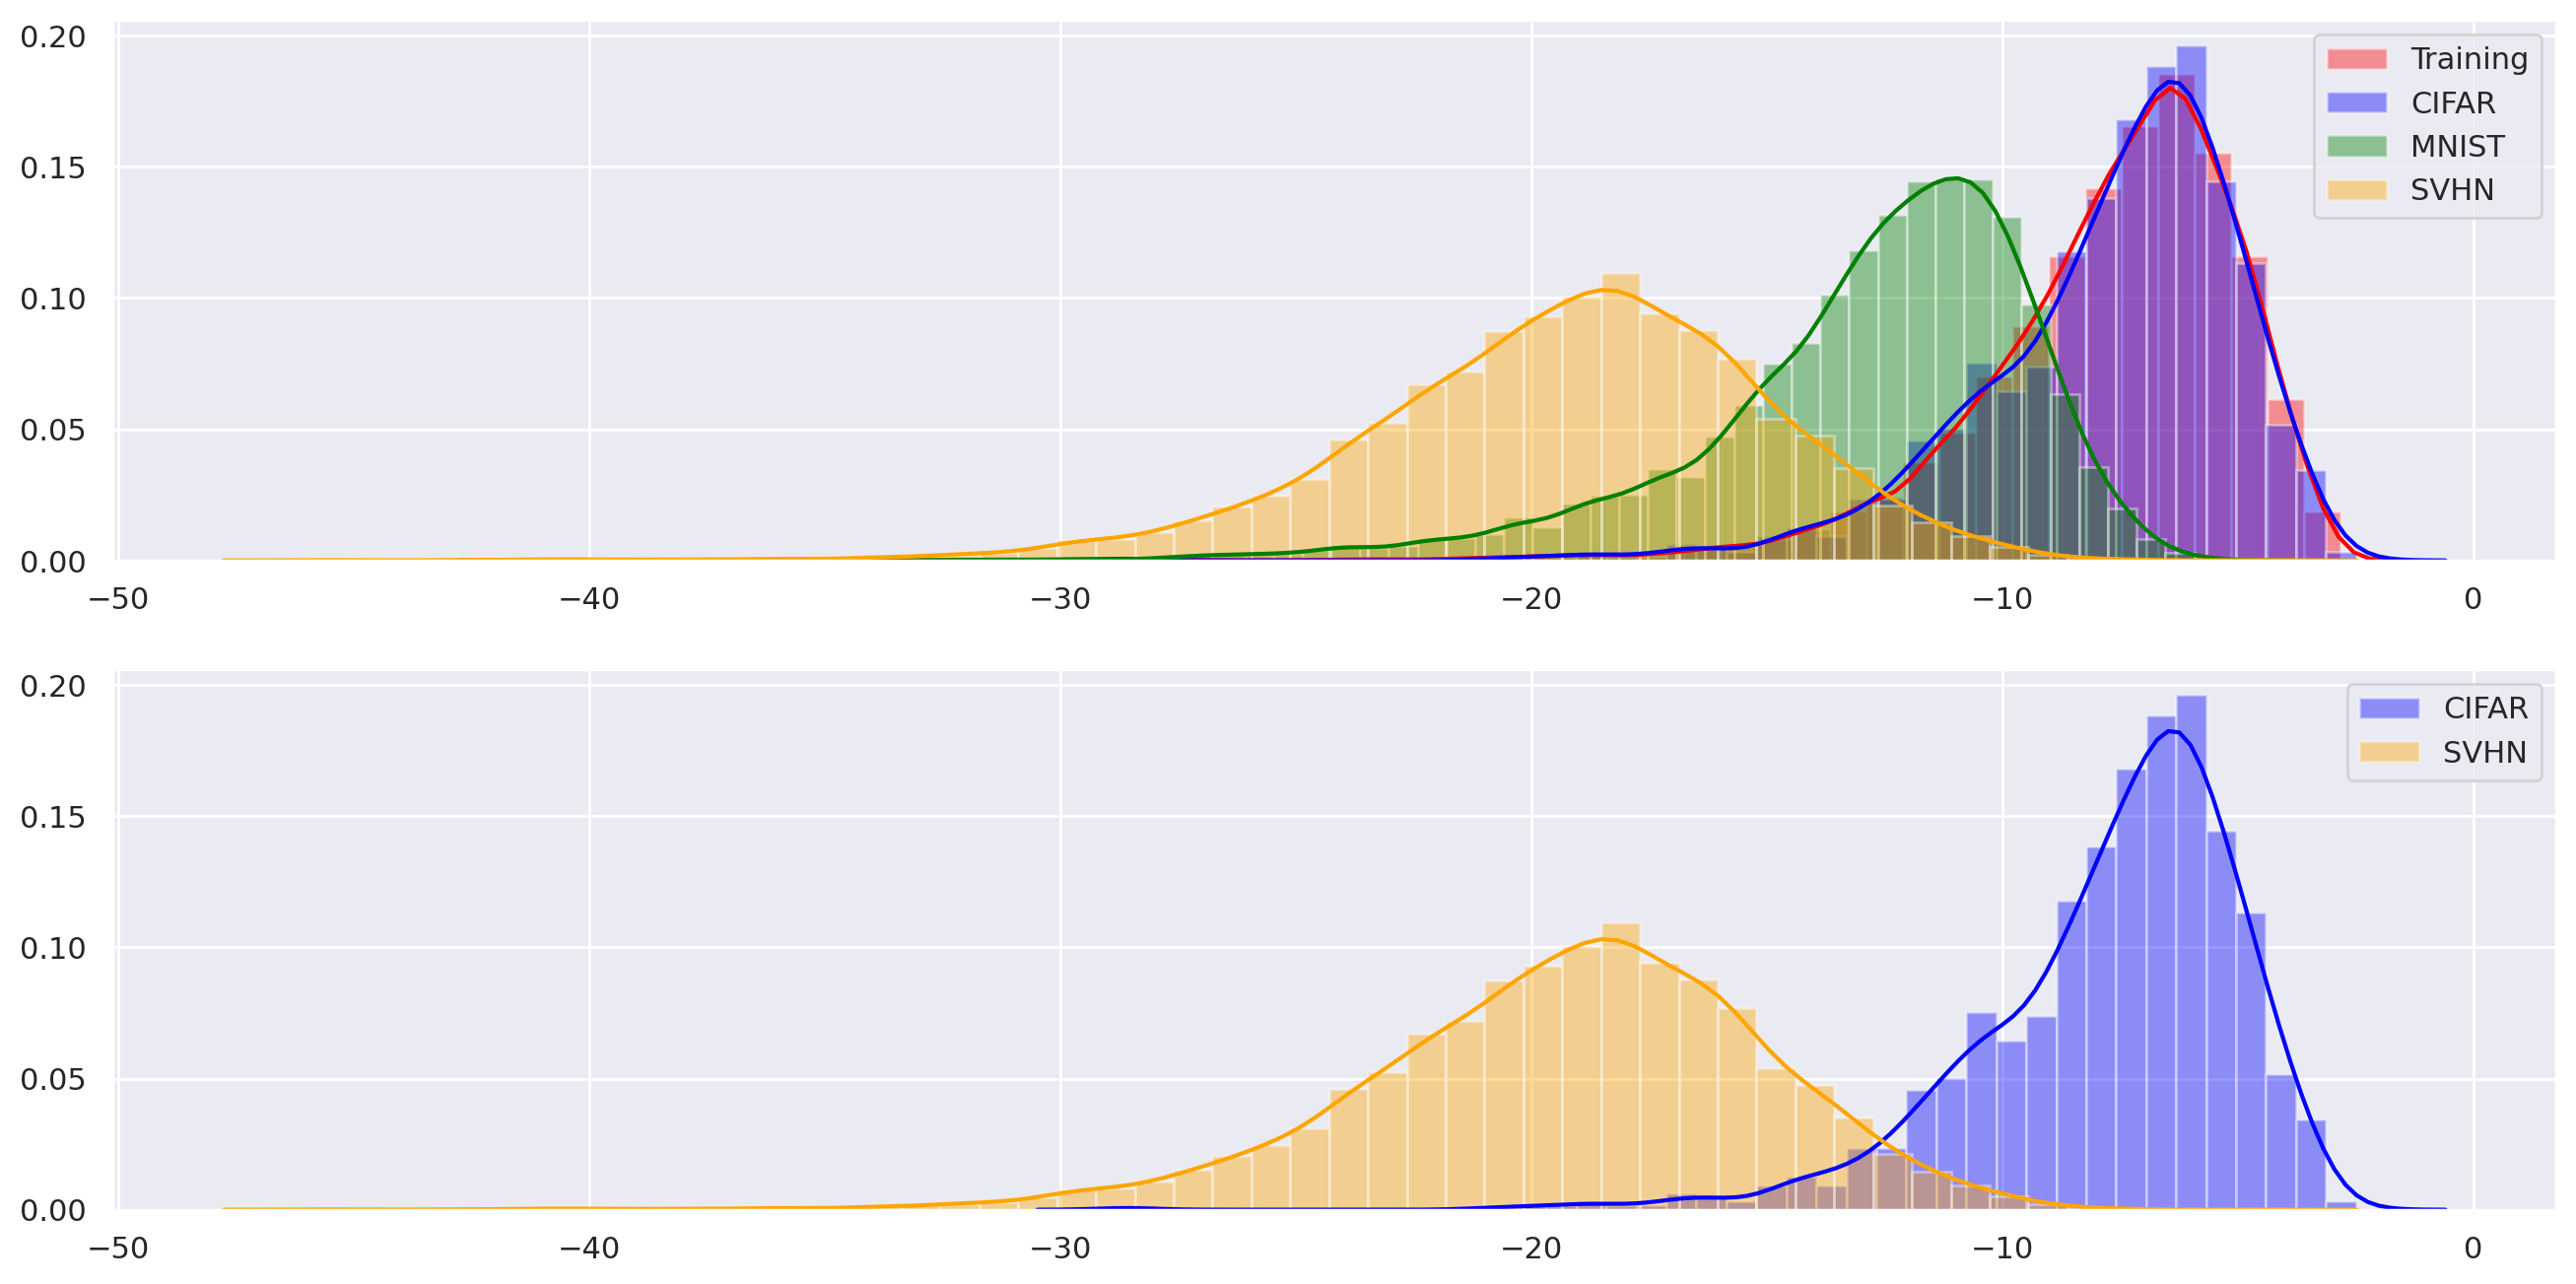

CPU times: user 2.3 s, sys: 232 ms, total: 2.53 s
Wall time: 2.52 s


In [83]:
%%time
train_score = distribution.log_prob(X_train, dtype=np.float32).numpy()
test_score = distribution.log_prob(X_test, dtype=np.float32).numpy()
outlier_score = distribution.log_prob(outlier_data_1, dtype=np.float32).numpy()
outlier_score_2 = distribution.log_prob(outlier_data_2, dtype=np.float32).numpy()

fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

In [85]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9880
PR-AUC: 0.9983
Avg Prec: 0.9983


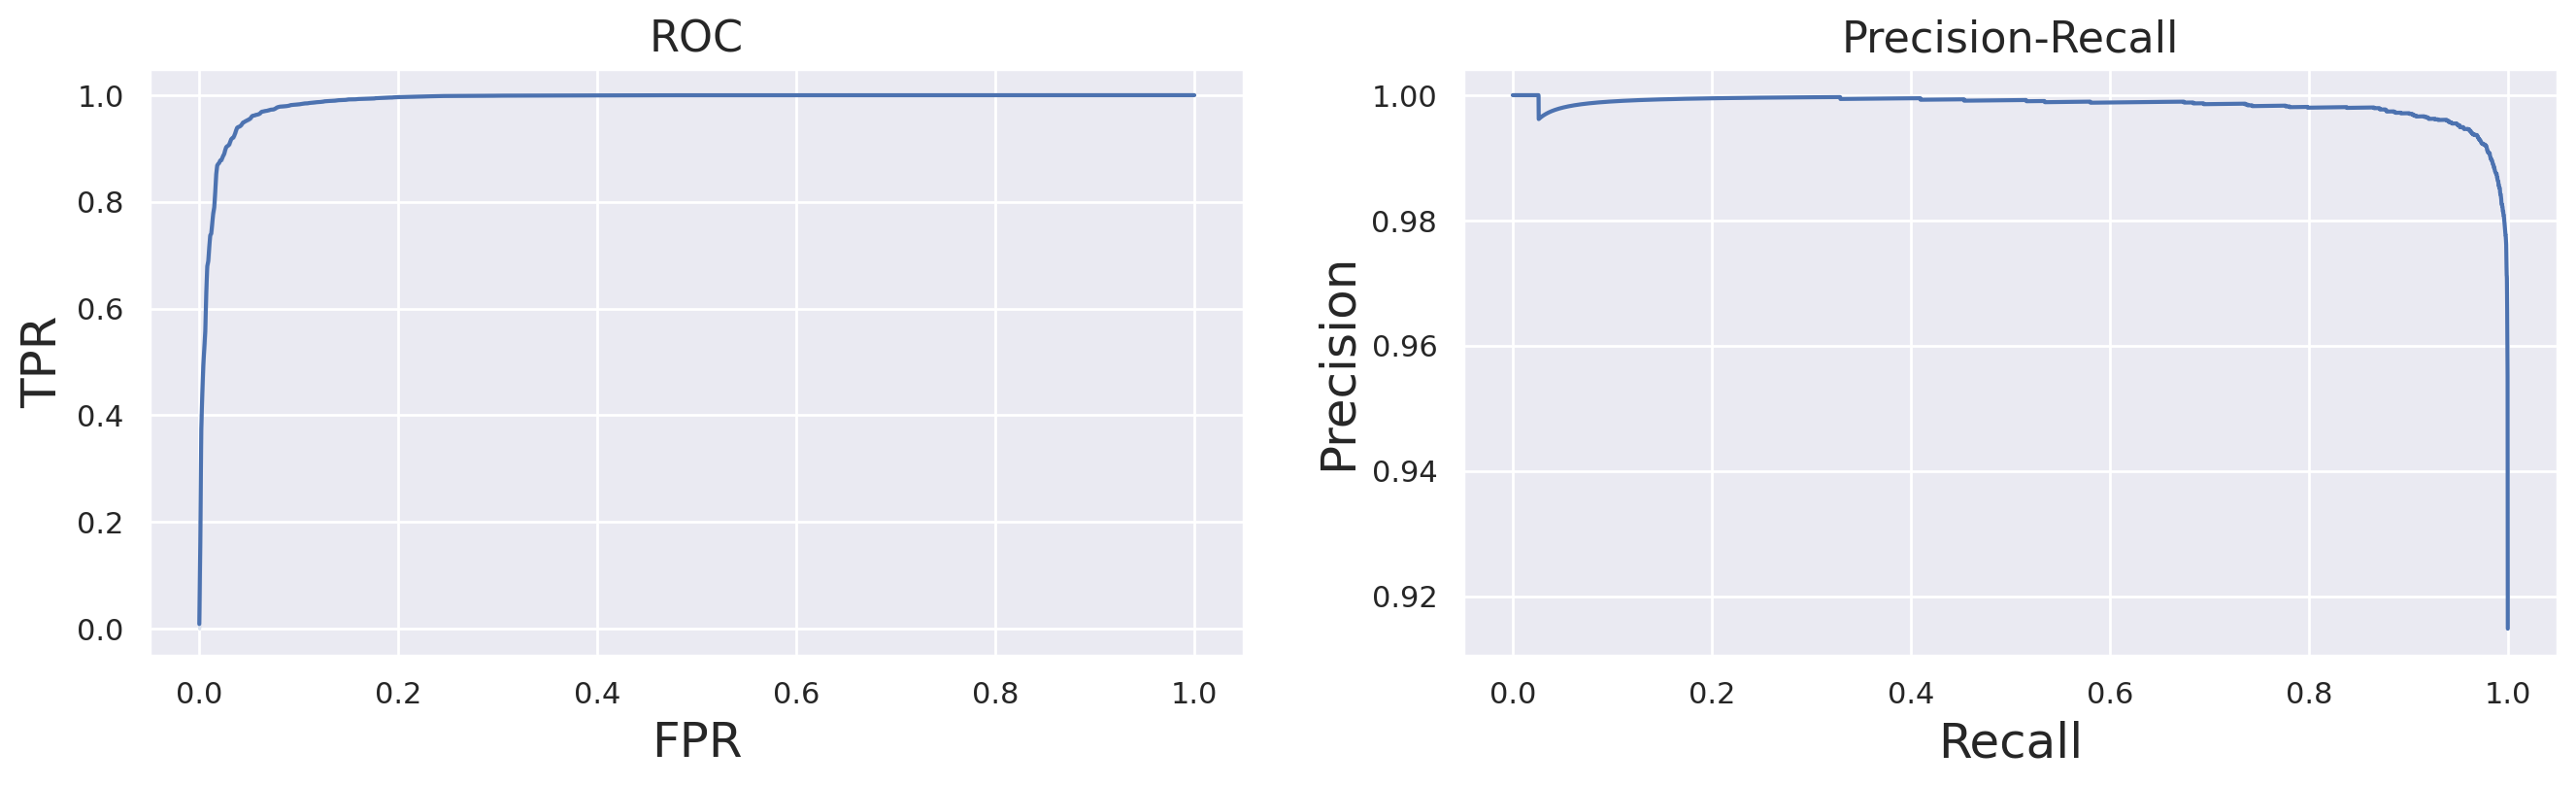

Inlier vs Outlier
----------------
ROC-AUC: 0.9880
PR-AUC: 0.9983
Avg Prec: 0.9983


In [87]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()

# UMAP

### Score Norms

In [87]:
samples_train = np.concatenate((test_data[:9000], outlier_data_1[:9000], outlier_data_2[:9000]))
samples_test  = np.concatenate((test_data[9000:], outlier_data_1[9000:], outlier_data_2[9000:]))

samples_train.shape

(27000, 10)

In [85]:
%%time
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=15,
                    min_dist=0.1)
reducer.fit(samples_train)

CPU times: user 59.2 s, sys: 1min 2s, total: 2min 2s
Wall time: 32 s


UMAP(n_components=3, random_state=42)

In [88]:
%%time
embedding = reducer.transform(samples_test)

CPU times: user 1.99 s, sys: 49.7 ms, total: 2.04 s
Wall time: 2.01 s


In [97]:
embedding.shape

(2962, 3)

In [96]:
[shapes[idx-1][0]-9000 for idx in range(1,4)]

[1000, 962, 1000]

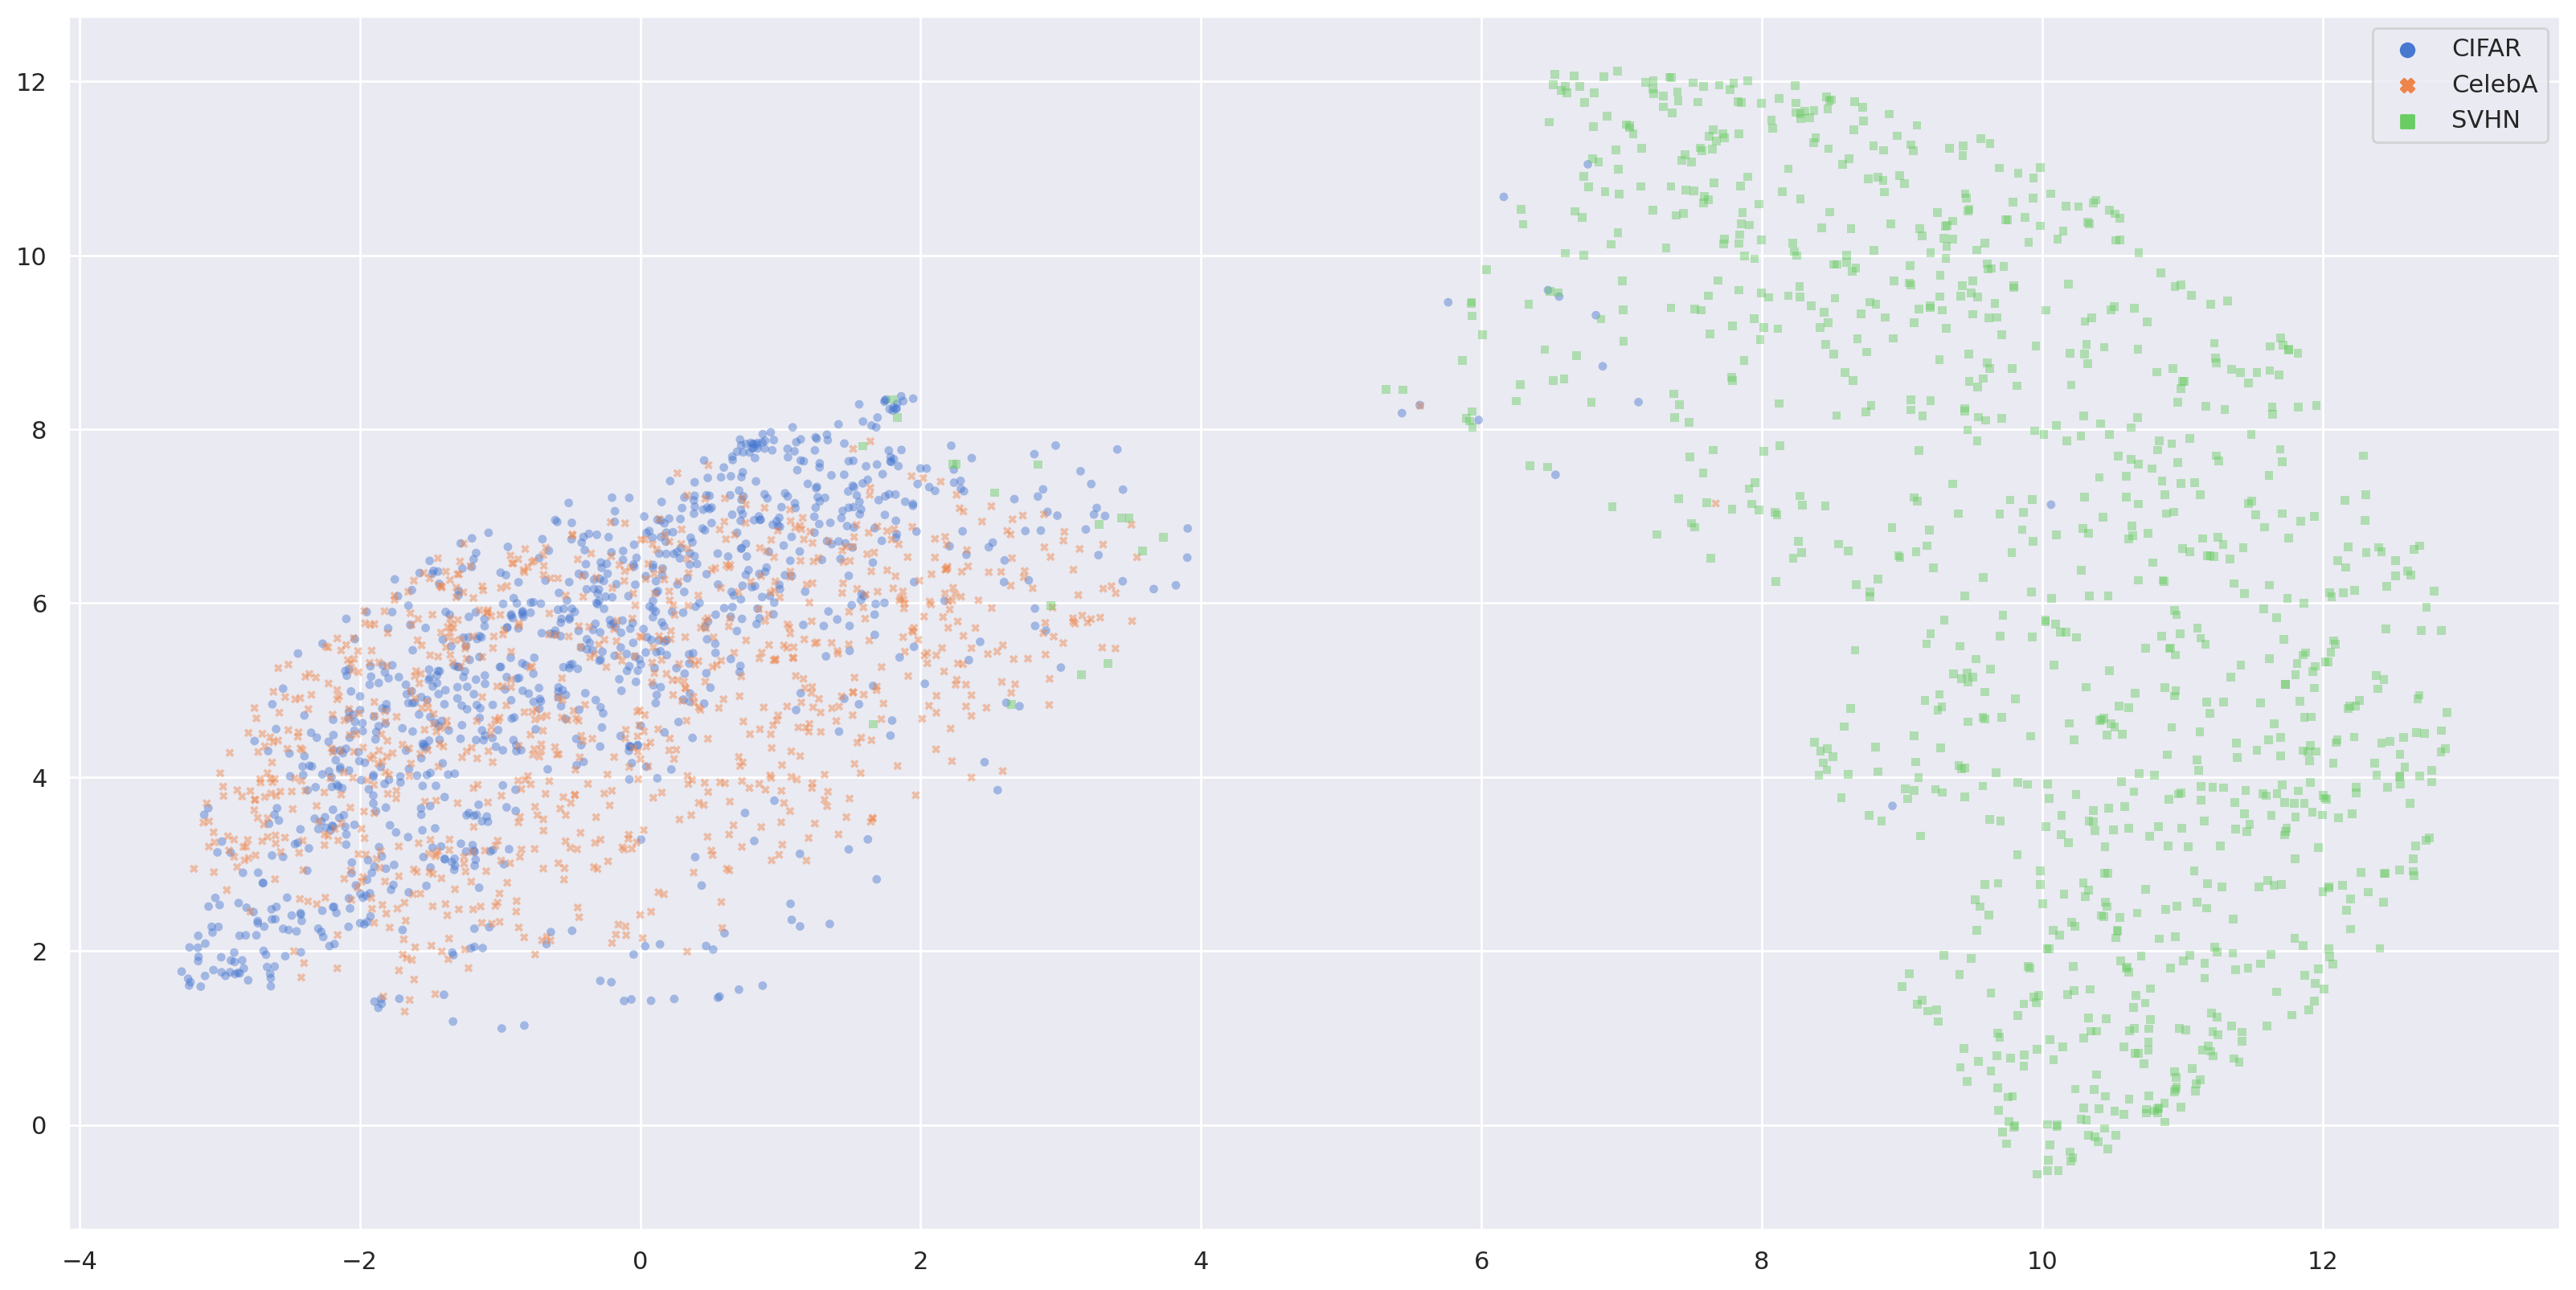

In [102]:
plt.figure(figsize=(20,10))

captions_test = np.concatenate([[LABELS[idx]]*(shapes[idx-1][0]-9000) for idx in range(1,4)])
labels_test = np.concatenate([[idx]*(shapes[idx-1][0]-9000) for idx in range(1,4)])
sns.scatterplot(x=embedding[:, 0],
                y=embedding[:, 1],
                hue=captions_test, style=captions_test, s=15, alpha=0.45, palette="muted", edgecolor="none")
plt.show()
# plt.close()

In [103]:
emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Score Norms",
    marker=dict(
        size=2,
        color=labels_test,
        colorscale="Blackbody",
        opacity=0.5,
        showscale=True
    ),
    text=captions_test
)

layout = go.Layout(
    title="3D UMAP",
    autosize=False,
    width=1000,
    height=800,
#     paper_bgcolor='#F5F5F5',
#     template="plotly"
)

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
fig.show("notebook")

## GMM on Embeddings

In [106]:
%%time
X_train_embedding = reducer.transform(X_train)
X_test_embedding = reducer.transform(X_test)
outlier_1_embedding = reducer.transform(outlier_data_1[9000:])
outlier_2_embedding = reducer.transform(outlier_data_2[9000:])

CPU times: user 9.6 s, sys: 340 ms, total: 9.94 s
Wall time: 9.82 s


In [155]:
outlier_train_embedding_1 = reducer.transform(outlier_data_1[:9000])
outlier_train_embedding_2 = reducer.transform(outlier_data_2[:9000])

In [107]:
X_train, X_test =  test_data[:9000], test_data[9000:]

In [131]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(20,101,10),
                  GMM__covariance_type = ['full']) # Full always performs best 

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train_embedding)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   38.6s finished


CPU times: user 59.3 s, sys: 8.16 s, total: 1min 7s
Wall time: 43.4 s


Best: -2.327967 using {'GMM__covariance_type': 'full', 'GMM__n_components': 100}
---------------------------------------------------------------------------
-2.662801 (0.046925) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
-2.573499 (0.042412) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 30}
-2.506286 (0.047969) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 40}
-2.454949 (0.040034) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 50}
-2.428373 (0.039311) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 60}
-2.401051 (0.052309) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 70}
-2.368396 (0.039467) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 80}
-2.348367 (0.041998) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 90}
-2.327967 (0.038845) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 100}


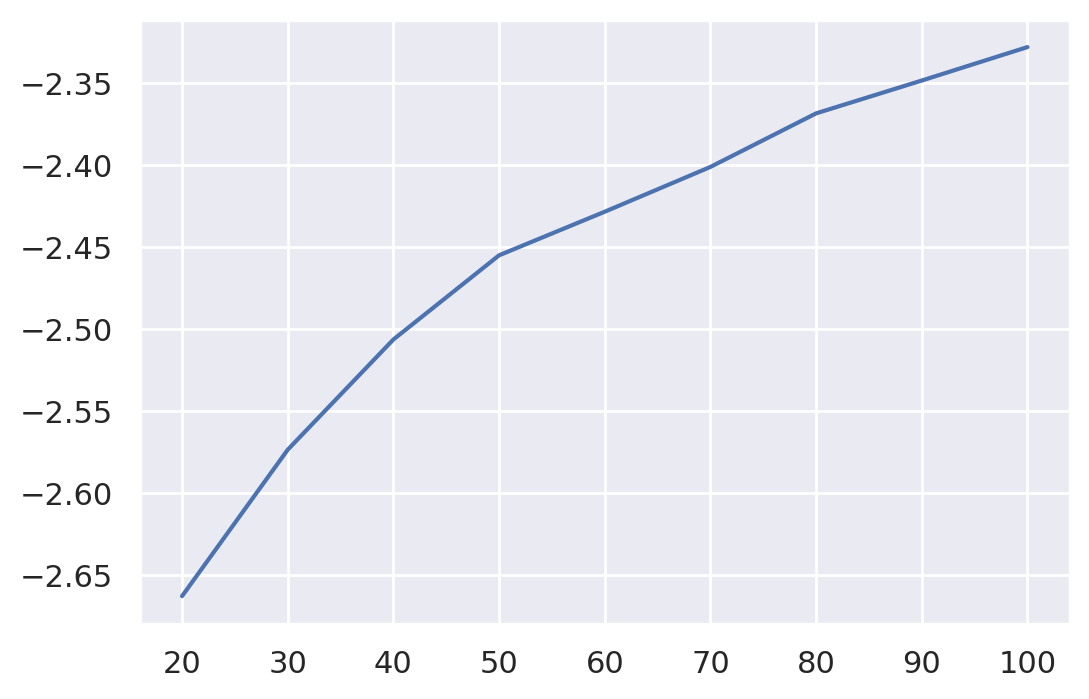

In [135]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
plt.plot([p["GMM__n_components"] for p in params], means)

In [143]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': 20})

best_gmm_clf.fit(X_train_embedding)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_1_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_2_embedding)))

Training Likelihood: -2.651
CIFAR Likelihood: -2.703
CelebA Likelihood: -4.148
SVHN Likelihood: -21.181


In [ ]:
Training Likelihood: -2.535
CIFAR Likelihood: -2.615
CelebA Likelihood: -4.136
SVHN Likelihood: -21.257

In [144]:
train_score = best_gmm_clf.score_samples(X_train_embedding)
test_score = best_gmm_clf.score_samples(X_test_embedding)
outlier_score = best_gmm_clf.score_samples(outlier_1_embedding)
outlier_score_2 = best_gmm_clf.score_samples(outlier_2_embedding)

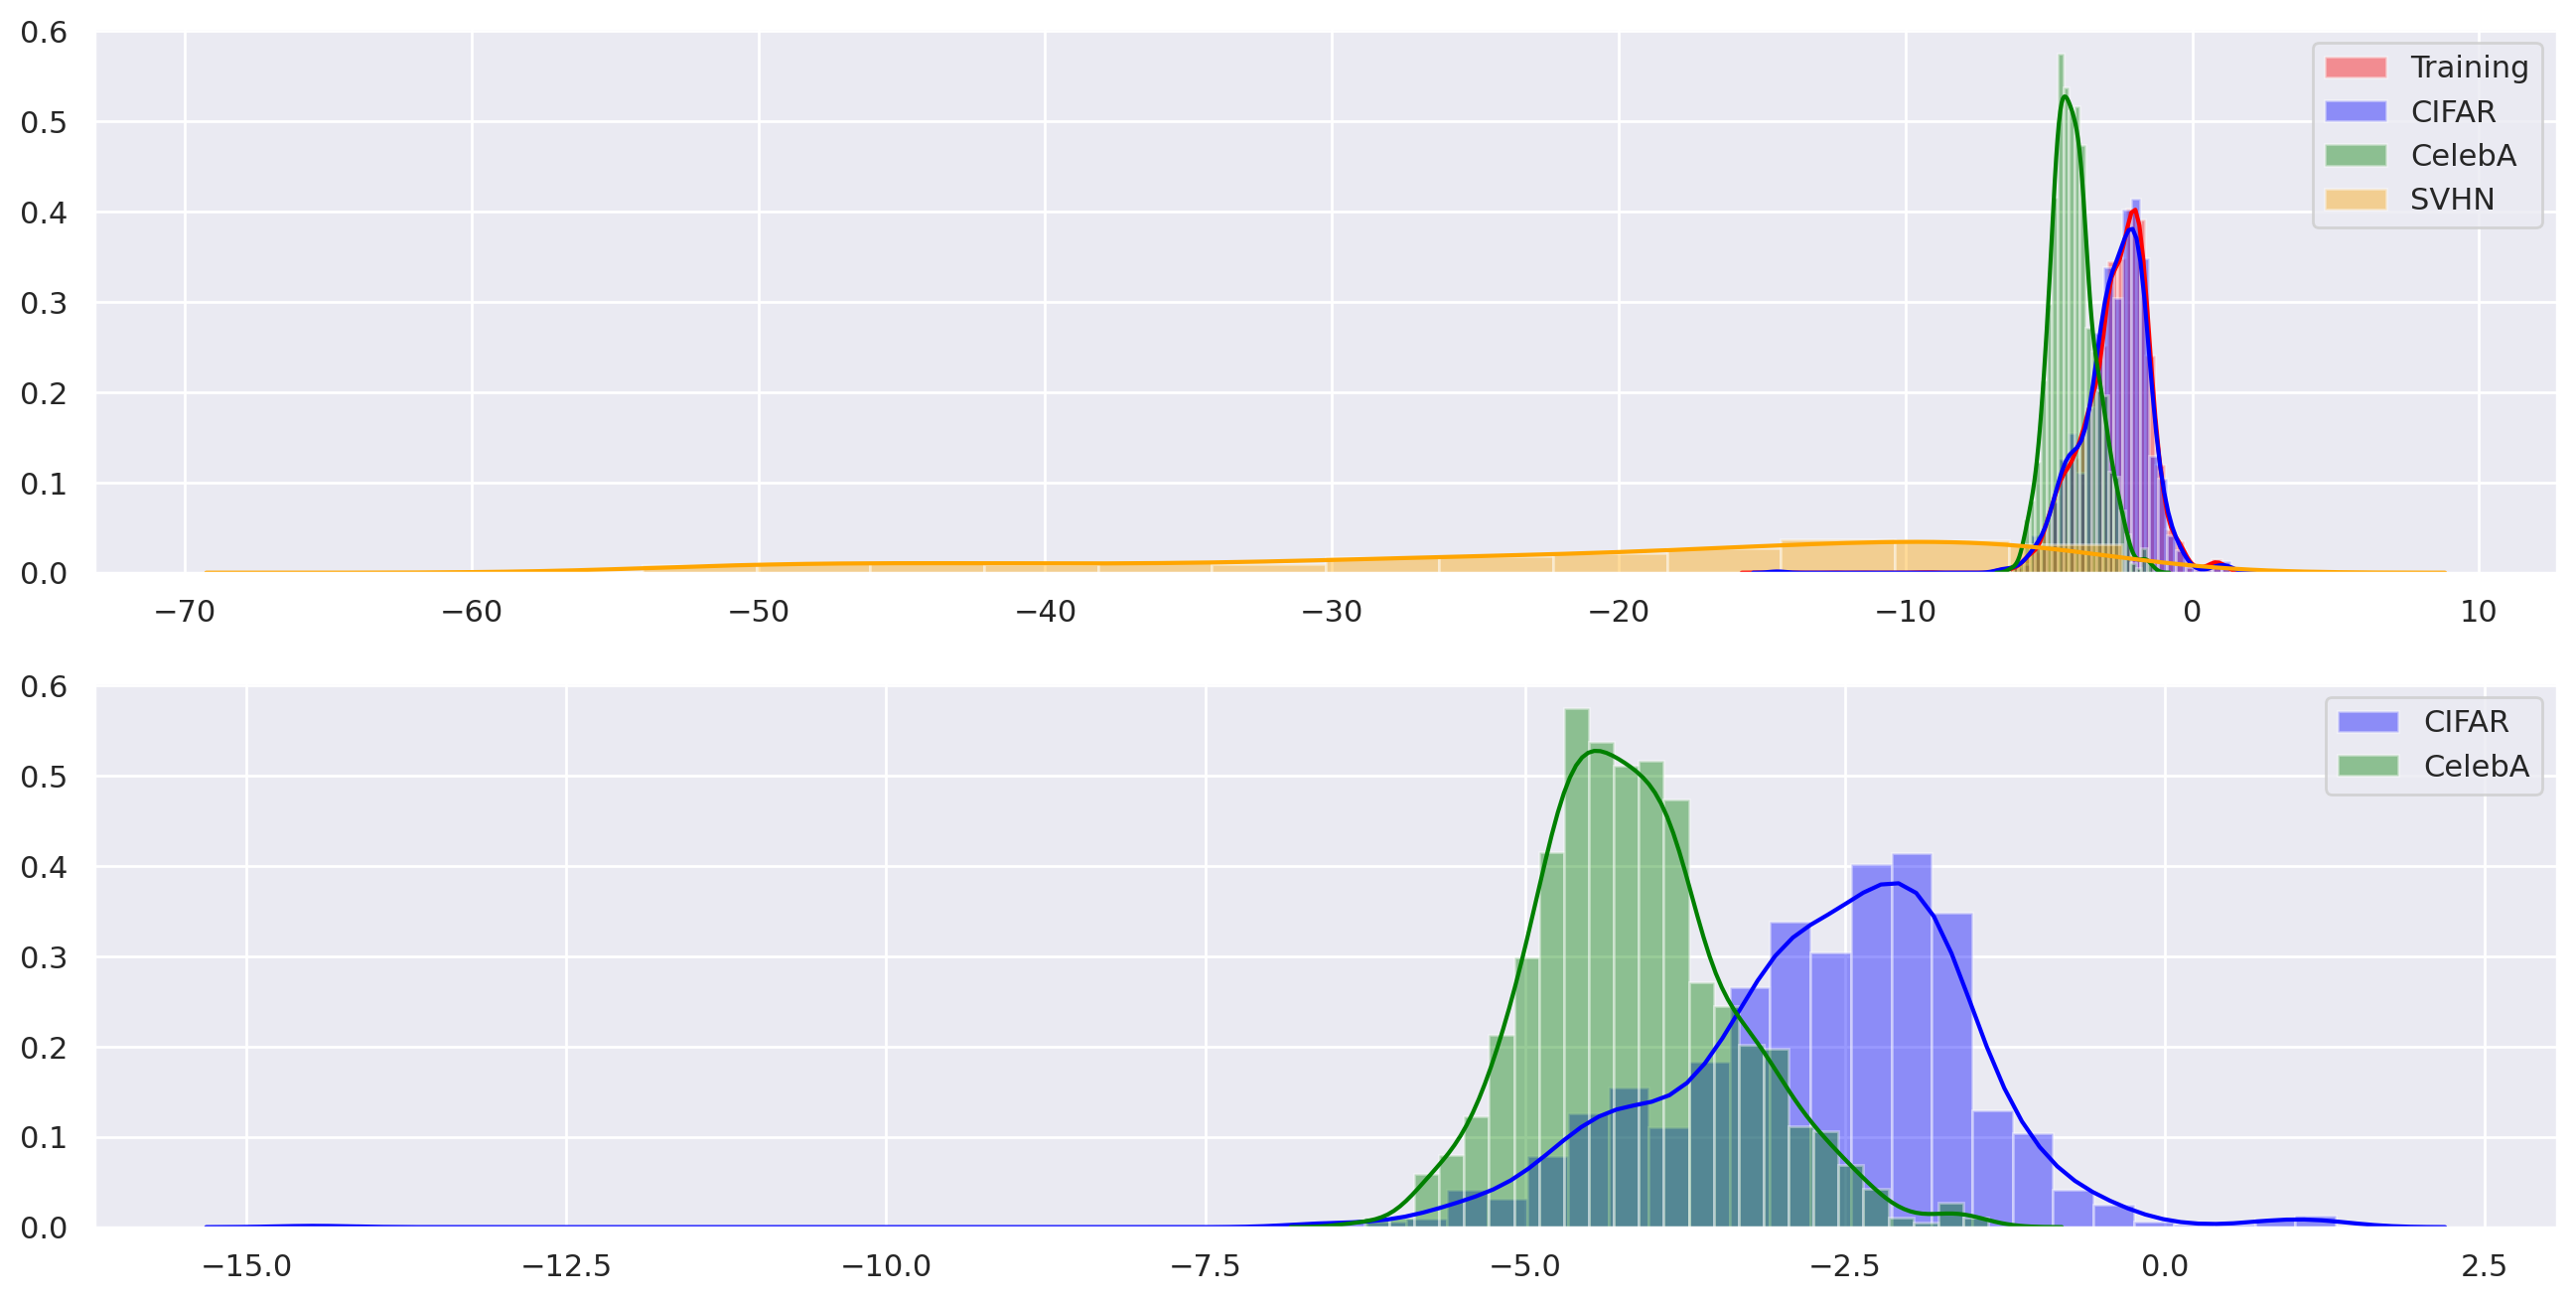

In [145]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score

def evaluate_GMM(n):
    gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train_embedding)
    
    test_score = gmm_clf.score_samples(X_test_embedding)
    outlier_score = gmm_clf.score_samples(outlier_train_embedding_1)
    outlier_score_2 = gmm_clf.score_samples(outlier_train_embedding_2)
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score)),
                             np.ones(len(outlier_score_2))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score, outlier_score_2))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

In [ ]:
%%time

max_n_component = 25
component_range = range(1, max_n_component+1, 1)

with ThreadPoolExecutor(max_workers = 6) as exc:
    result = list(exc.map(evaluate_GMM, component_range))
    
result = np.array(result)

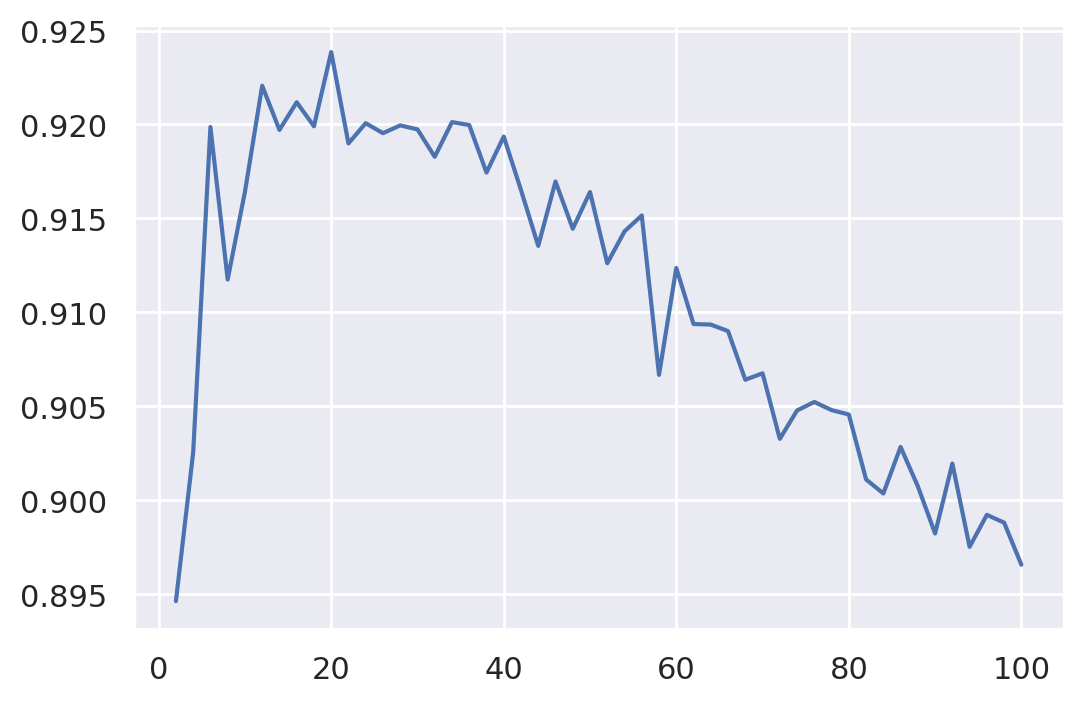

In [166]:
plt.plot(component_range, result)

print("Best -> {}:{:.3f} ".format(component_range[np.argmax(result)], np.max(result)))

In [ ]:
y_true = np.concatenate((np.zeros(len(inlier_score)),
                         np.ones(len(outlier_score))))
y_scores = np.concatenate((inlier_score, outlier_score))


roc_auc = roc_auc_score(y_true,y_scores)

In [151]:
metrics(-test_score, -np.concatenate((outlier_score, outlier_score_2)), plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9197
PR-AUC: 0.9564
Avg Prec: 0.9564


**CIFAR vs CelebA**

In [146]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.8493
PR-AUC: 0.7716
Avg Prec: 0.7724


**CIFAR vs SVHN**

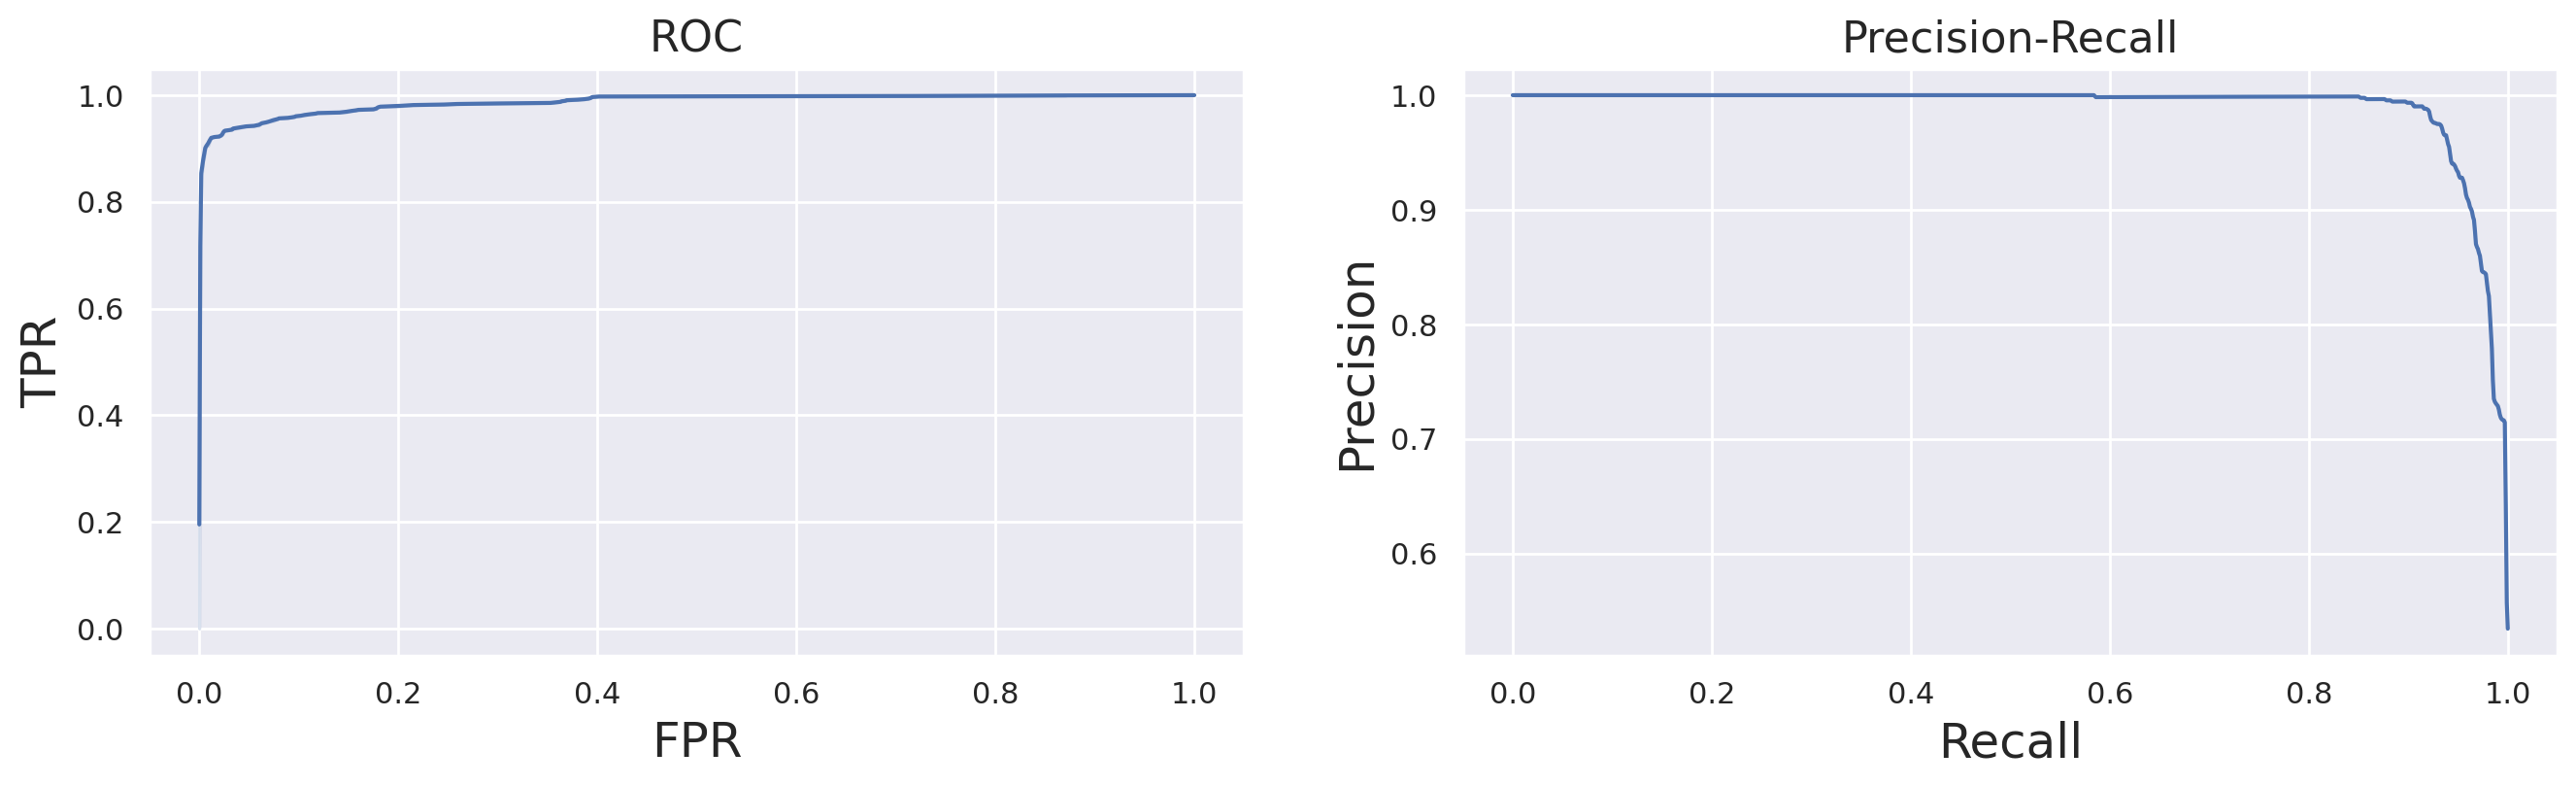

Inlier vs Outlier
----------------
ROC-AUC: 0.9868
PR-AUC: 0.9893
Avg Prec: 0.9893


In [119]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()